In [1]:
import pandas as pd
from pathlib import Path

In [2]:
path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/sp_para entrenar/'
pathlist = Path(path).glob('*.csv')
sparks_data_list = []
for file in pathlist:
    path_in_str = str(file)
    df = pd.read_csv(path_in_str)
    sparks_data_list.append(df)
sparks_data_list = pd.concat(sparks_data_list)
del (sparks_data_list['Unnamed: 0'])
del (sparks_data_list['minim'])
del (sparks_data_list['FWHM'])
del (sparks_data_list['pos_x'])
del (sparks_data_list['pos_y'])
del (sparks_data_list['FDHM'])
del (sparks_data_list['full_width'])
del (sparks_data_list['sparks_tiempo_pico50_2'])
del (sparks_data_list['tiempo_minimo'])

In [3]:
sparks_data_list.to_csv(path + 'sparks_data_list.csv')

In [4]:
#Disabling the warnings permantently
import warnings
warnings.filterwarnings('ignore')

In [5]:
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier


from sklearn.model_selection import (RandomizedSearchCV,
                                     KFold,
                                     cross_val_score,
                                     train_test_split)
from sklearn.metrics import (roc_auc_score,
                             make_scorer,
                             classification_report,
                             roc_curve,
                             f1_score,
                             matthews_corrcoef,
                             precision_score,
                             recall_score,
                             confusion_matrix)

from xgboost import XGBClassifier

In [6]:
sparks_data_list.isnull().sum()

tiempo_maximo           122
intensidad_maxima       122
intensidad_minima       122
tiempo_valle            122
intensidad_valle        122
sparks_amplitud         122
TTP                     122
sparks_tiempo_pico50    122
sp_tau                  656
TTP50                   122
fullWidth               122
(ΔF/F0)/ΔTmax           122
fullDuration            122
width                     0
high                      0
flag                      0
dtype: int64

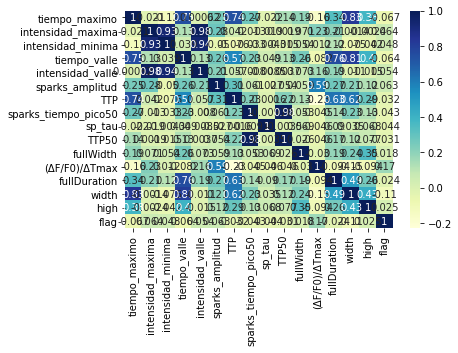

In [7]:
corr = sparks_data_list[sparks_data_list.columns].corr()
sns.heatmap(corr, cmap="YlGnBu", annot = True)
sns.set(rc={'figure.figsize':(30,24)})

In [8]:
X = sparks_data_list.drop(['flag'], axis=1).values
y = sparks_data_list.flag

In [9]:
X_train,X_test,  y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.3,
                                                    stratify=y)

In [10]:
df_train = pd.DataFrame(y_train)
df_test = pd.DataFrame(y_test)

In [11]:
print(df_train.groupby('flag').size())
print(df_test.groupby('flag').size())

flag
1.0    1558
2.0    1797
dtype: int64
flag
1.0    668
2.0    771
dtype: int64


In [12]:
from sklearn.impute import SimpleImputer

# Tratamiento de NaN
imp = SimpleImputer(missing_values=np.nan, strategy='median') # Uso el promedio para reemplazar
imp.fit(X_train)
X_train = imp.transform(X_train)

imp.fit(X_test)
X_test = imp.transform(X_test)

In [13]:
model_baseline = XGBClassifier()

In [14]:
model_baseline.fit(X_train, y_train)

[17:32:24] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [15]:
def get_prediction(predictions):
    new_preds = []
    for preds in predictions:
        if preds >= 0.25:
            new_preds.append(1)
        else: new_preds.append(2)
    return new_preds

In [16]:
pred_proba_train = model_baseline.predict_proba(X_train)[:, 1]
pred_proba_test = model_baseline.predict_proba(X_test)[:, 1]

pred_train = get_prediction(pred_proba_train)
pred_test = get_prediction(pred_proba_test)

In [17]:
print(f"Train ROC-AUC: {np.round(roc_auc_score(y_train, pred_proba_train), 2)}")
print(f"Test ROC-AUC: {np.round(roc_auc_score(y_test, pred_proba_test), 2)}")

Train ROC-AUC: 1.0
Test ROC-AUC: 0.94


In [21]:
import Image_Sparks
import cv2
import sparks_analysis
import image_class

# path = '/media/leandro/Volumen1TB/Lean/Analizador_imagenes_calcio/Sp/Imagenes_confocal/sp_para entrenar/'
image = image_class.Image_Processing('/media/leandro/Volumen1TB/Lean/Curso MLIP/', 'c5ac007')


image = cv2.imread(image.path + image.photo_name + ".tif")
imcrop = Image_Sparks.Image_Sparks.Image_cropping(image)
cv2.imwrite('/path/to/destination/image.png',imcrop)
contours, img_processed = Image_Sparks.Image_Sparks.Image_processing(imcrop)
list_img_col, list_img_row, x_position, y_position, width, high = Image_Sparks.Image_Sparks.Image_analysis(contours, img_processed, image)


# # Detect each event and give it a category
# def write_points(event, x_position, y_position, flags, param):
#     if event == cv2.EVENT_LBUTTONDOWN:
#         img_points.append(flags)
#     if event == cv2.EVENT_RBUTTONDOWN:
#         img_points.append(flags)
# winname="TAG :: Press ESC to exit; left Click to TAG 1; right Click to TAG 2"
# cv2.namedWindow(winname)
# img_points = []
# cv2.setMouseCallback(winname,write_points)
# while True:
#     cv2.imshow(winname,img_processed)
#     cv2.imshow('original',image)
#     if cv2.waitKey(20) & 0xFF ==27:
#         break      
# cv2.destroyAllWindows()

# Take the processing data to analyze each spark and extract parameters

parameters = sparks_analysis.analysis_process (list_img_col, list_img_row,x_position,y_position,width,high, img_points)
print(parameters)

# parameters.to_csv(path + photo_name + '_canny400_f3_b100')

TypeError: analysis_process() missing 1 required positional argument: 'flag'